# Random Local Feature Aggregation model

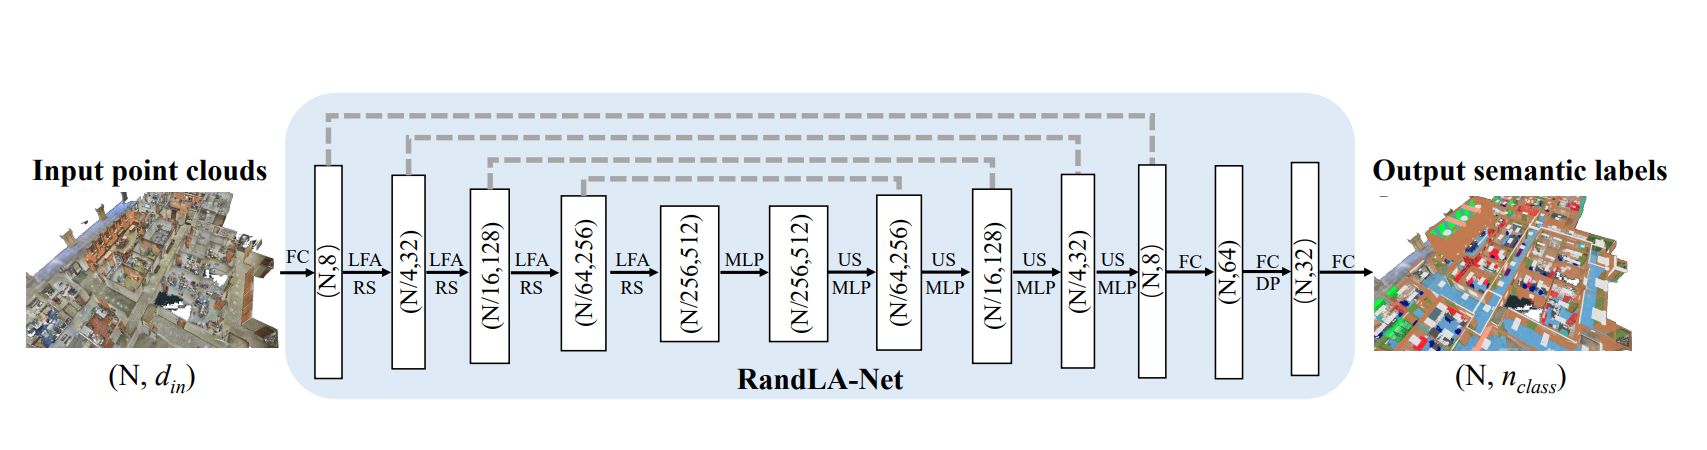

## 1. Назначение модели

RandLA-Net предназначена для семантической сегментации больших разреженных облаков точек, где стандартные point-based архитектуры перегружаются из-за квадратичной сложности по числу точек. Модель оптимизирована для работы с миллионами точек без процесса вокселизации.

## 2. Ключевая идея

RandLA-Net достигает высокой производительности за счет двух принципов.

### 2.1. Случайное подвыборочное прореживание

На каждом уровне применяется случайная выборка точек (random sampling) вместо сложного кластеризации или KNN-subsampling. Это дает линейную сложность по числу точек.

### 2.2. Механизм локального внимания

Чтобы не потерять качество из-за случайного прореживания, используется блок локального внимания, который агрегирует информацию от соседей с весами, зависящими от локальной геометрии.

## 2. Архитектура


Архитектура RandLA‑Net является иерархической моделью сегментации облаков точек, опирающейся на две ключевые идеи:
* случайное равновероятное семплирование точек
* локальную агрегацию признаков с использованием механизма внимания.

Пусть исходное облако точек на уровне $l$ имеет размерность $N_l$ и содержит признаки размерности $F_l$. На каждом уровне энкодера число точек уменьшается в четыре раза, а размерность признаков растёт.

```bash
Input (N_0, 3)
        |
        v
+--------------------------------+
|        Encoder Layer 1         |
|  Sampling: N_0 → N_1           |
|  Feature: 3 → F_1              |
+--------------------------------+
        |
        v
+--------------------------------+
|        Encoder Layer 2         |
|  Sampling: N_1 → N_2           |
|  Feature: F_1 → F_2            |
+--------------------------------+
        |
        v
+--------------------------------+
|        Encoder Layer 3         |
|  Sampling: N_2 → N_3           |
|  Feature: F_2 → F_3            |
+--------------------------------+
        |
        v
+--------------------------------+
|        Encoder Layer 4         |
|  Sampling: N_3 → N_4           |
|  Feature: F_3 → F_4            |
+--------------------------------+
        |
        v
Bottleneck (N_4, F_4)
        |
        v
+--------------------------------+
|        Decoder Layer 1         |
|  Upsample N_4 → N_3            |
|  Concat with skip F_3          |
+--------------------------------+
        |
        v
+--------------------------------+
|        Decoder Layer 2         |
|  Upsample N_3 → N_2            |
|  Concat with skip F_2          |
+--------------------------------+
        |
        v
+--------------------------------+
|        Decoder Layer 3         |
|  Upsample N_2 → N_1            |
|  Concat with skip F_1          |
+--------------------------------+
        |
        v
Classification Head
```

### Input

На вход подаётся множество:
$$
P_l = \{p_i \in \mathbb{R}^3\}_{i=1}^{N_l}.
$$

### Случайное семплирование

Случайное семплирование выбирает подмножество точек следующего уровня:
$$
P_{l+1} \subset P_l, \quad |P_{l+1}| = \frac{N_l}{4},
$$
при этом вероятность выбора каждой точки равна:
$$
\mathbb{P}(p_i \in P_{l+1}) = \frac{1}{N_l}.
$$
Этот механизм принципиально важен, так как позволяет отказаться от дорогих процедур поиска ключевых точек.

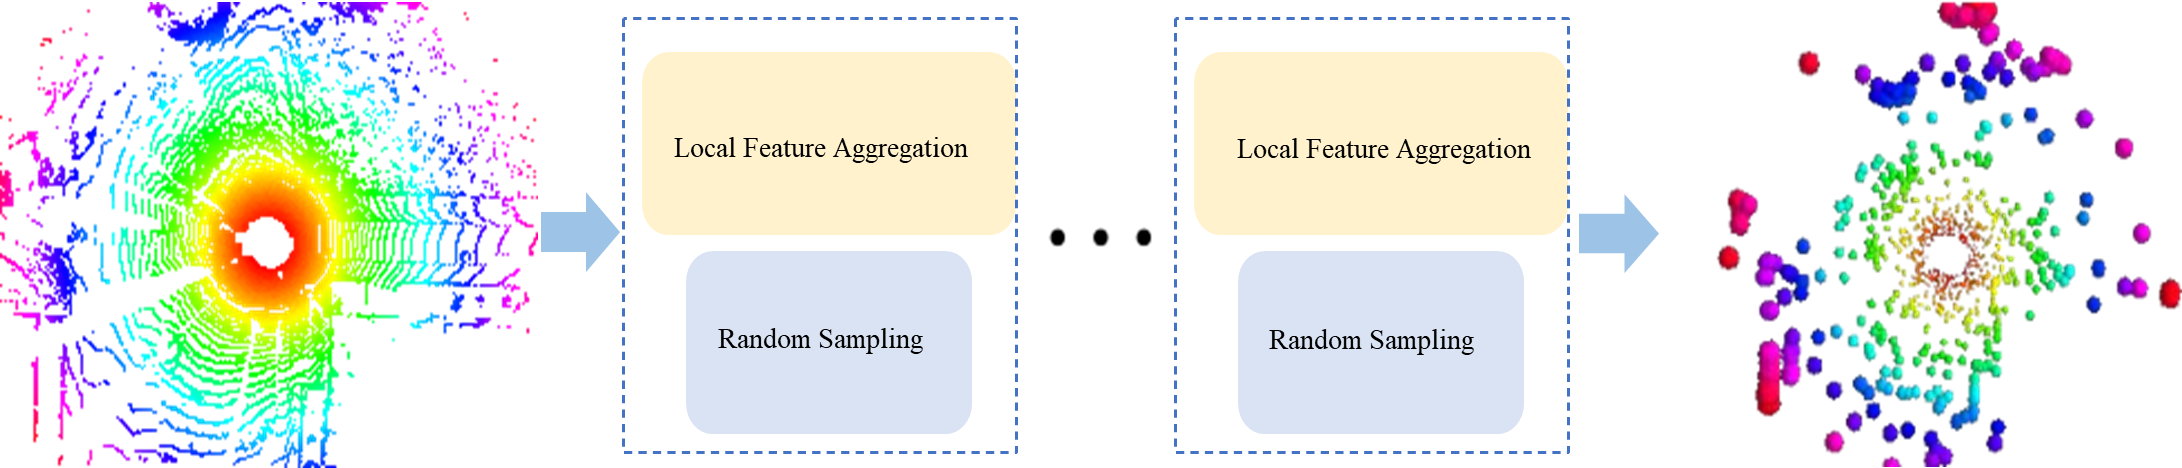

### Поиск ближайших соседей

После семплирования для каждой новой точки $p_i$ определяется множество ближайших соседей:
$$
\mathcal{N}(p_i) = \{p_{ij}\}_{j=1}^{K},
$$
что формирует тензор входных признаков для локальной обработки размерности:
$$
X_i \in \mathbb{R}^{K \times F_l}.
$$

### Local Feature Aggregation (LFA)

Затем применяется модуль локальной агрегации признаков LFA:

```bash
Input (K, F_l)
        |
        v
+-----------------------------+
|  MLP1: F_l → F_l            |
+-----------------------------+
        |
        v
+-----------------------------+
|  MLP2: F_l → 2F_l           |
+-----------------------------+
        |
        v
+-----------------------------+
| Local Pooling (max + avg)   |
| Output: 2F_l                |
+-----------------------------+
        |
        v
+-----------------------------+
| Attention Weights (softmax) |
+-----------------------------+
        |
        v
+-----------------------------+
| Weighted Sum (F_l)          |
+-----------------------------+

```

LFA преобразует набор из **K соседей** одной точки в **единый итоговый вектор признаков**. Разберём процесс по шагам.

---

#### Шаг 1. Локальное преобразование признаков соседей

**Операция:** два последовательных MLP‑слоя, применяемых к каждому соседу индивидуально.


1. **Первое преобразование** (MLP1):  
   $$
   h_{ij} = \phi(x_{ij}), \quad \text{где } \phi: \mathbb{R}^{F_l} \rightarrow \mathbb{R}^{F_l}.
   $$  
    Преобразует исходные признаки соседа $x_{ij}$ в промежуточное представление $h_{ij}$.

2. **Второе преобразование** (MLP2):  
   $$
   u_{ij} = \varphi(h_{ij}), \quad \text{где } \varphi: \mathbb{R}^{F_l} \rightarrow \mathbb{R}^{2F_l}.
   $$  
    Увеличивает размерность признаков до $2F_l$, усиливая выразительность.

**Цель:** локальная нелинейная фильтрация признаков каждого соседа без их объединения.


#### Шаг 2. Извлечение сильных и общих локальных признаков

**Операции:** max‑pooling и average‑pooling по всем соседям.

1. **Максимальное агрегирование** (max pooling):  
   $$
   m_i = \max_{j=1..K} u_{ij}.
   $$  
    Выбирает **наиболее выраженные** признаки среди соседей (доминирующие локальные особенности).

2. **Среднее агрегирование** (average pooling):  
   $$
   a_i = \frac{1}{K} \sum_{j=1}^{K} u_{ij}.
   $$  
    Даёт **усреднённую характеристику** локальной области (общие черты окружения).

3. **Объединение результатов**:  
   $$
   z_i = [m_i, a_i] \in \mathbb{R}^{2F_l}.
   $$  
    Конкатенация $m_i$ и $a_i$ в единый контекстный вектор размерности $2F_l$.

    После формирования $z_i$ в оригинальной RandLA-Net выполняется дополнительный этап контекстного обновления признаков. Сначала из $z_i$ формируется контекстный вектор центральной точки:

    $$
    c_i = \rho(z_i),
    $$

    где $\rho$ — небольшой MLP, приводящий объединённый локальный контекст к размерности (F_l). Далее этот контекст добавляется к каждому локальному признаку соседа:

    $$
    \tilde{h}_{ij} = h_{ij} + c_i.
    $$

    Именно обновлённые признаки $\tilde{h}_{ij}$ используются при вычислении скалярных весов внимания и в дальнейшей агрегации.

---

**Цель:** захват как локальных экстремумов, так и общих тенденций в окрестности.


#### Шаг 3. Вычисление скалярной важности каждого соседа

**Операция:** одноканальный MLP + softmax для получения весов внимания.


1. **Оценка значимости** (MLP):  
   $$
   e_{ij} = \psi(h_{ij}), \quad \text{где } \psi: \mathbb{R}^{F_l} \rightarrow \mathbb{R}.
   $$  
    Для каждого соседа $h_{ij}$ вычисляется скалярный вес $e_{ij}$.

2. **Нормализация** (softmax):  
   $$
   \alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{K} \exp(e_{ik})}.
   $$  
    Преобразует веса в вероятностное распределение ($\sum_j \alpha_{ij} = 1$).

    **Цель:** определение **важности каждого соседа** для итоговой агрегации (механизм внимания).

#### Шаг 4. Сборка признаков соседей с учётом важности

**Операция:** взвешенное суммирование (weighted sum pooling).


$$
f_i = \sum_{j=1}^{K} \alpha_{ij} h_{ij}.
$$

- $\alpha_{ij}$ - нормализованный вес соседа $j$ (из шага 3);
- $h_{ij}$ - преобразованные признаки соседа (из шага 1).

**Цель:** формирование итогового локального признака точки с акцентом на наиболее значимые соседи.

#### Шаг 5. Пост‑обработка итогового признака


**Операция:** линейный слой с нормализацией и активацией.

$$
\text{Output} = \text{ReLU}\big(\text{BN}(W \cdot f_i + b)\big),
$$
где:
- $W$ - матрица весов линейного слоя;
- $b$ - смещение;
- BN - Batch Normalization;
- ReLU - функция активации.

**Цель:** приведение признака к итоговой размерности $F_{l+1}$ и стабилизация обучения.

---

### Итоговая структура LFA (сводная таблица)

| Шаг | Операция | Назначение |
|------|--------|-----------|
| 1 | MLP₁ ($F_l \rightarrow F_l$) | Локальное преобразование признаков соседей |
| 2 | MLP₂ ($F_l \rightarrow 2F_l$) | Расширение выразительности признаков |
| 3 | Max pooling | Выделение доминирующих локальных признаков |
| 4 | Average pooling | Извлечение общей статистики окружения |
| 5 | MLP + softmax | Расчёт весов внимания для соседей |
| 6 | Weighted sum | Агрегация признаков с учётом важности |
| 7 | Linear + BN + ReLU | Постобработка и приведение к итоговой размерности $F_{l+1}$ |

**Результат:** для каждой точки получается вектор $f_i \in \mathbb{R}^{F_{l+1}}$, учитывающий как локальную структуру, так и значимость соседей.

### 3.1. Encoder

Архитектура построена как последовательность уровней со структурами:

1. Случайное подвыборочное прореживание.
2. Поиск соседей методом k-ближайших точек.
3. Блок локального внимания (Local Feature Aggregation Block):

   * MLP для извлечения базовых признаков.
   * Механизм внимания для взвешивания соседей.
   * Объединение признаков соседей в новый эмбеддинг.

Число точек уменьшается, число каналов признаков растет.

Схема одного блока энкодера:

```bash
Input (N_l, F_l)
        |
        v
+-----------------------------+
| Random Sampling             |
| N_l → N_l/4                 |
+-----------------------------+
        |
        v
+-----------------------------+
| Neighbor Search (K-NN)      |
| → (N_l/4, K, F_l)           |
+-----------------------------+
        |
        v
+-----------------------------+
| Local Feature Aggregation   |
| → (N_l/4, F'_l)             |
+-----------------------------+
        |
        v
+-----------------------------+
| Linear Layer + BN + ReLU    |
| F'_l → F_{l+1}              |
+-----------------------------+
Output (N_{l+1}, F_{l+1})

```

**Цель энкодера:**  
* уменьшить количество точек;  
* увеличить выразительность признаков;  
* выделить более абстрактные структуры сцены.

Работа каждого уровня энкодера состоит из четырёх шагов.


---

#### Шаг 1. Случайное семплирование

**Формула:**  
$$
P_{l+1} \subset P_l,\quad |P_{l+1}| = N_l/4.
$$

**Объяснение:**  
Мы берём четверть точек из уровня $l$.  
Это делается случайно, без каких‑либо умных правил.

**Цель:**  
быстро уменьшить количество точек, чтобы дальнейшая обработка была дешёвой.



#### Шаг 2. Поиск соседей

**Формально:**  
$$
\mathcal{N}(p_i) = \{ p_{ij} \}_{j=1}^K.
$$

**Объяснение:**  
Для каждой выбранной точки ищем $K$ ближайших соседей, но не среди новых (сэмплированных), а среди старых (более плотных).

**Цель:**  
сохранить информацию высокой плотности вокруг каждой точки.



#### Шаг 3. LFA — локальная агрегация

**Формула (финальный выход):**  
$$
f_i = \sum_{j=1}^K \alpha_{ij} h_{ij}.
$$

**Объяснение:**  
Это уже разобрано раньше — LFA строит локальный признак, комбинируя соседей.

**Цель:**  
каждой точке теперь сопоставляется локальный признак, описывающий её окружение.



#### Шаг 4. Линейное преобразование признаков

**Формула:**  
$$
F'_l \rightarrow F_{l+1}.
$$

**Объяснение:**  
Признаки, которые создал LFA, пропускаются через `Linear + BN + ReLU`.  
Это увеличивает их размерность и создаёт более высокоуровневое представление.



**Итог одного слоя энкодера:**

* **Вход:** $(N_l, F_l)$;  
* **Выход:** $(N_{l+1} = N_l/4, F_{l+1})$.

Мало точек, но много признаков.

---

### 3.2. Decoder

Постепенное восстановление разрешения с передачей признаков через skip connections. Признаки интерполируются с помощью KNN interpolation.

Декодер выполняет обратное восстановление плотности точек. Для этого coarse‑признаки поднимаются до исходной плотности с помощью ближайшего соседа:
$$
f(p_k) = f(q_{\mathrm{nn}(k)}),
$$
где $q_{\mathrm{nn}(k)}$ - ближайшая точка coarse‑уровня к fine‑точке $p_k$.

После этого новые признаки конкатенируются с пропущенными признаками энкодера.

Схема одного блока декодера:

```bash
Input (coarse) (N_l, F_l)
Skip  (fine)   (N_l*4, F_skip)
                |
                v
+--------------------------------+
| Nearest Neighbor Upsample      |
| N_l → N_l*4                    |
+--------------------------------+
                |
                v
+--------------------------------+
| Concatenate F_l + F_skip       |
+--------------------------------+
                |
                v
+--------------------------------+
| MLP: (F_l + F_skip) → F_{l-1}  |
+--------------------------------+
Output (N_l*4, F_{l-1})

```

**Цель декодера:**  
* вернуть плотность точек на исходный уровень;  
* объединить абстрактные признаки (из энкодера) с подробными признаками нижних уровней.

Каждый уровень декодера состоит из трёх шагов.

---

#### Шаг 1. Upsample — восстановление числа точек

**Формула:**  
$$
f(p_k) = f(q_{\mathrm{nn}(k)}),
$$  
где $q$ — coarse‑точки, $p$ — fine‑точки.

**Объяснение:**  
Для каждой точки более плотного уровня находим ближайшую coarse‑точку и копируем её признаки.

* Было 250 000 точек.  
* Декодер поднимает их обратно до 1 000 000.  
* Признаки новых точек просто копируются от ближайших старых.


#### Шаг 2. Concat со skip‑connection

**Формула:**  
$$
\text{concat}(\text{upsampled\_}F, F_{\text{skip}}).
$$

**Объяснение:**  
Берём признаки, полученные при upsample, и объединяем их с признаками того же уровня из энкодера (skip‑connection).

* Признаки энкодера содержат локальные детали.  
* Признаки upsample содержат глобальный контекст.

**Цель:**  

* Берём старые признаки из энкодера уровня 1.  
* Склеиваем с признаками, поднятыми из bottleneck.


#### Шаг 3. MLP (сжатие признаков обратно)

**Формально:**  
$$
(F_l + F_{\text{skip}}) \rightarrow F_{l-1}.
$$

**Объяснение:**  
После конкатенации у нас слишком много каналов.  
MLP уменьшает их до нормального размера.

---

**Финальный выход декодера:**

По итогам $L$ уровней:  
* было: $N_4$ точек;  
* стало: $N_0$ точек (как в начале).

И теперь каждая точка снова имеет свой признак, но гораздо более информативный, используя всю пирамидальную структуру сети.

---

### Короткое резюме

**ENCODER:**  
1. Семплирование: уменьшили количество точек.  
2. KNN: получили соседей.  
3. LFA: собрали локальный признак.  
4. Linear: сделали его более абстрактным.

**DECODER:**  
1. Upsample: вернули плотность точек.  
2. Concat со skip: объединяем глобальное и локальное.  
3. MLP: приводим признаки в порядок.

### 3.3. Классификатор

В RandLA-Net классификация точек выполняется **мультиуровневым классификатором**, который агрегирует информацию со всех уровней декодера.
Это важно, потому что признаки на разных уровнях имеют различную природу:

* верхние уровни дают глобальный контекст
* нижние уровни дают локальные детали

Чтобы эффективно объединить всё это, RandLA-Net использует **multi-scale prediction**.

---

1. Логиты на каждом уровне декодера

После каждого upsample блока декодера сеть получает признаки:

* после первого upsample --> (F_3)-канальные признаки
* после второго upsample --> (F_2)-канальные признаки
* после третьего upsample --> (F_1)-канальные признаки

Для каждого из них проходит простая линейная классификация (один слой):

$$
\ell_i^{(l)} = W^{(l)} f_i^{(l)} + b^{(l)}
$$

где:

* $ l \in {1,2,3} $ — уровень декодера
* $ f_i^{(l)} $ — признак точки i на уровне l
* $ \ell_i^{(l)} \in \mathbb{R}^C $ — логиты классов

Это даёт три набора логитов для одних и тех же точек — с разными масштабами информации.


2. Суммирование логитов

RandLA-Net использует **multi-scale fusion**, чтобы итоговая классификация учитывала все уровни семантической детализации:

$
g_i = \sum_{l=1}^L \ell_i^{(l)}
$

где L = 3 (по числу уровней декодера).

Преимущества:

1. Объединение глобального и локального контекста.
2. Устойчивость к шуму: если один уровень ошибся, другой его корректирует.
3. Эффект ансамблевой классификации без дополнительной стоимости.


3. Финальная голова

После суммирования логитов может стоять дополнительная голова (зависит от реализации):

$$
g_i^\star = W_2 , \sigma(W_1 g_i + b_1) + b_2.
$$

Это двухслойный MLP, который повышает выразительность и позволяет модели подстроить классификацию под совмещённые признаки.


4. Softmax

Вероятности классов:

$$
p_i(c) = \frac{\exp(g_i^{(c)})}{\sum_{m=1}^{C} \exp(g_i^{(m)}) }.
$$

5. Полная функция сети

$$
S(P) = \mathrm{Softmax}\big( H(D(E(P))) \big).
$$

Где:

* (E) — encoder
* (D) — decoder
* (H) — multi-scale classifier

---


```bash
                      +----------------+
Decoder Level 1 ----> | Linear (F1→C)  | ---> logits_1
                      +----------------+
                               |
                               |
                      +----------------+
Decoder Level 2 ----> | Linear (F2→C)  | ---> logits_2
                      +----------------+
                               |
                               |
                      +----------------+
Decoder Level 3 ----> | Linear (F3→C)  | ---> logits_3
                      +----------------+
                               |
                               |
                               v
                 +--------------------------------+
                 |   SUM logits_1 + logits_2 +    |
                 |            logits_3             |
                 +--------------------------------+
                               |
                               v
                   summed_logits = g_i
                               |
                               v
                     +----------------------+
                     |  Final Head Layer 1  |
                     |   Linear + ReLU      |
                     +----------------------+
                               |
                               v
                     +----------------------+
                     |  Final Head Layer 2  |
                     |     Linear → C       |
                     +----------------------+
                               |
                               v
                         final_logits g_i*
                               |
                               v
                          Softmax → p_i

```

### Функции потерь

Semantic Segmentation это **multi-class per-point classification**, поэтому основная функция потерь - Cross Entropy.

Но из-за несбалансированности SemanticKITTI используются специальные модификации.

---

1. Взвешенная Cross Entropy (Weighted CE)

Основная функция:

$$
\mathcal{L}*{CE}
= -\sum*{i=1}^{N} w_{y_i} \log p_i(y_i),
$$

где:

* $w_{y_i}$ - вес класса
* $p_i(y_i)$ - предсказанная вероятность истинного класса

Веса компенсируют экстремальную несбалансированность SemanticKITTI:
классы типа road, building доминируют; bush, motorcycle встречаются редко.

---

2. Multi-Scale Loss

Поскольку сеть Predicts логиты на нескольких масштабах, для каждого уровня декодера есть свой CE-лосс:

$$
\mathcal{L}^{(l)} =
-\sum_{i} w_{y_i} \log p_i^{(l)}(y_i)
$$

Итоговая функция:

$$
\mathcal{L}*{total}
= \sum*{l=1}^{L} \lambda_l , \mathcal{L}^{(l)},
$$

где:

* $L = 3$ - уровни декодера
* $\lambda_l$ - веса (обычно равные, $\lambda_l = 1$)

То есть обучение происходит на всех масштабах.


# Самостоятельная работа

**Обучить модель используя следующие инструменты:**

* Модификации конфига модели
* Выбора другой модели